In [2]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# # To show the interactive widgets 
# %matplotlib widget
# from Pyriod import Pyriod #!This hates me. So just using LK
# import warnings

# # Suppress warning from Astropy module 
# # astropy.stats used in Pyriod is no longer supported
# from astropy.utils.exceptions import AstropyDeprecationWarning
# warnings.filterwarnings("ignore", category=AstropyDeprecationWarning)

# # Suppress invalid value runtime warning from Astropy and Pyriod 
# warnings.filterwarnings("ignore", category=RuntimeWarning) 

# from IPython.display import Image

# import lightkurve as lk

2.963548492989503 d


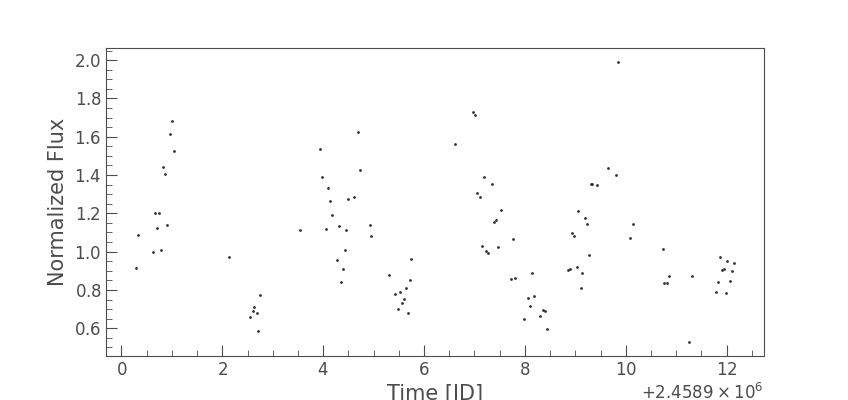

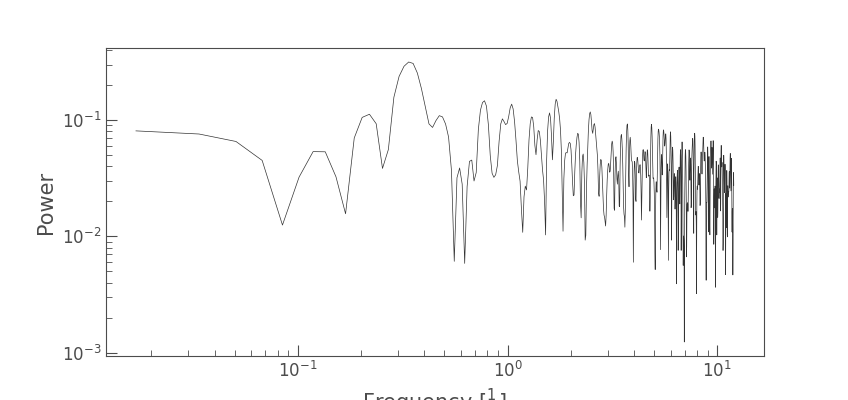

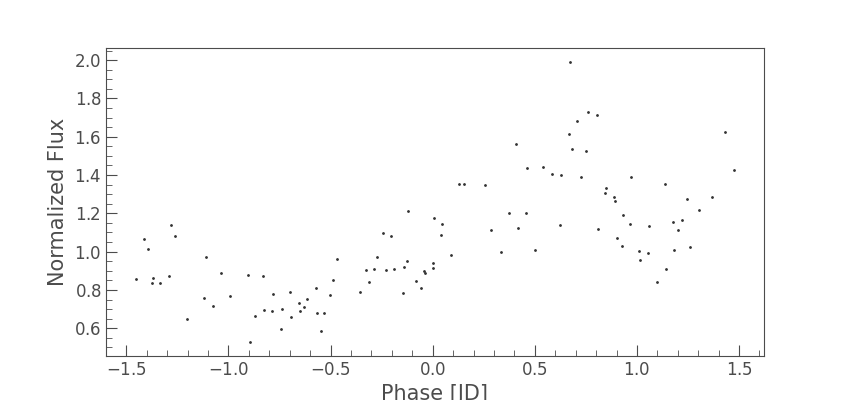

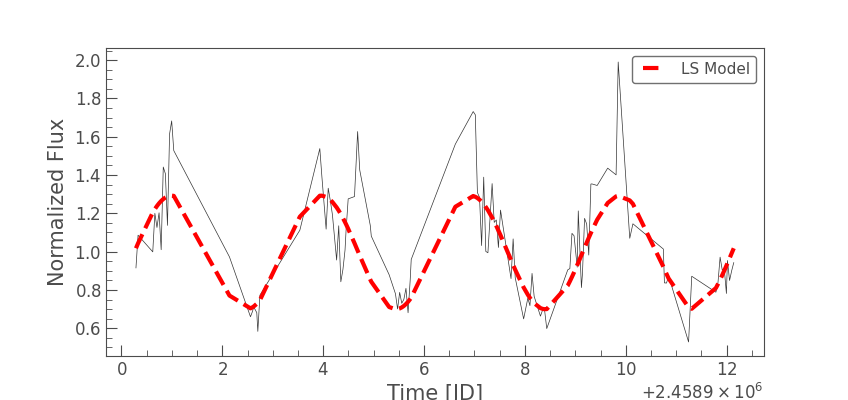

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
import astropy.units as u
%matplotlib widget



def lcPlots(fName):
    """
    Uses LightKurve to make LC plots from just a filename of a csv with flux and Time cols.
    """
    data = pd.read_csv(fName)
    fluxes = data["flux"]
    times = data["Time"]

    fluxErrs = np.ones_like(fluxes)*1e-4 #lk needs errors

    lc =lk.LightCurve(data=None, time=times, flux=fluxes, flux_err=fluxErrs)
    lc = lc.normalize()
    lc.scatter()
    pg = lc.to_periodogram()

    pg.plot(scale="log")
    period = pg.period_at_max_power
    print(period)
    lc.fold(period).scatter()

    lcModel = pg.model(time=lc.time, frequency=pg.frequency_at_max_power)
    ax = lc.plot()
    lcModel.plot(ax=ax, lw=3, ls='--',c='red')
    return lcModel


objName = " 1999 JE82 "


fName = f"./{objName}Matches.csv"
lcm = lcPlots(fName=fName)



{'_required_columns_relax': False,
 '_required_columns': ['time', 'flux', 'flux_err'],
 '_masked': False,
 '_column_class': astropy.table.column.Column,
 'columns': <TableColumns names=('time','flux','flux_err')>,
 'formatter': <astropy.table.pprint.TableFormatter at 0x7fa5d4b00fa0>,
 '_copy_indices': True,
 '_init_indices': True,
 'primary_key': None,
 '_meta': {'FREQUENCY': <Quantity 0.33743332 1 / d>,
  'TARGETID': 'None LS Model',
  'LABEL': 'LS Model',
  'NORMALIZED': True},
 '_first_colname': 'time',
 '_required_columns_enabled': True,
 'pprint_exclude_names': <PprintIncludeExclude name=pprint_exclude_names value=None>,
 'pprint_include_names': <PprintIncludeExclude name=pprint_include_names value=None>,
 '_new_attributes_relax': False}

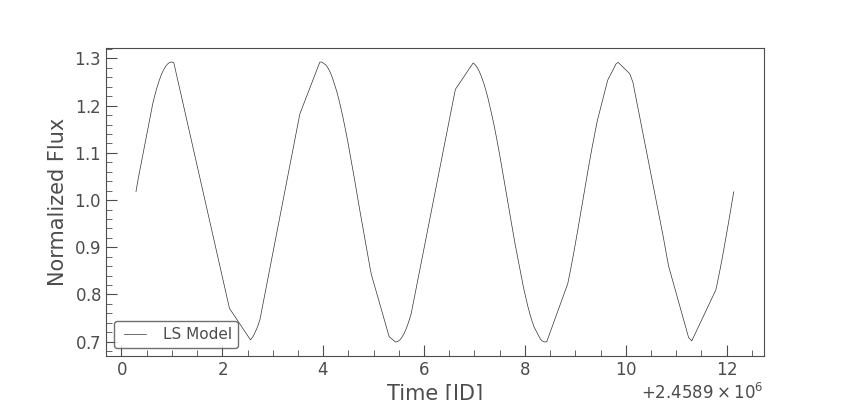

In [4]:
lcm.plot()
vars(lcm)


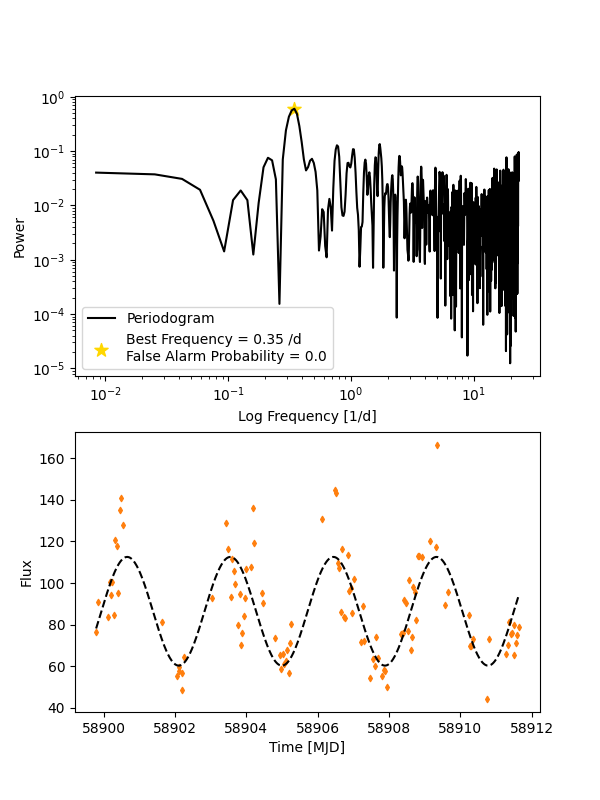

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib widget

from astropy.timeseries import LombScargle as lsp


fName = f"./{objName}Matches.csv"
data = pd.read_csv(fName)
fluxes = data["flux"]
times = data["Time"]-2400000.5


lsper = lsp(times*u.day, fluxes)#.autopower(samples_per_peak=50)
freqs, powers = lsper.autopower()
bestPow = np.max(powers)
bestFreq = freqs[np.argmax(powers)]
t_fit=np.linspace(times.min(),times.max(),1000)
y_fit = lsper.model(t_fit, bestFreq)

f_a_prob = lsper.false_alarm_probability(np.max(powers))

modelParams = lsper.model_parameters(bestFreq)

fig, ax = plt.subplots(2, figsize = (6,8))

ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set(xlabel="Log Frequency [1/d]", ylabel="Power")
ax[0].plot(freqs, powers, c="k", label="Periodogram")
ax[0].scatter(bestFreq,bestPow, c="gold",marker="*", s=100, label=f"Best Frequency = {bestFreq.round(2)} /d \nFalse Alarm Probability = {f_a_prob.round(3)}")
ax[0].legend()

ax[1].set(xlabel="Time [MJD]", ylabel="Flux")
ax[1].scatter(times, fluxes, label = "Light curve", c="tab:orange", marker = "d", s=10)
ax[1].plot(t_fit,y_fit, ls="--", c="k", label="Model")







In [91]:
lcdbDAT = pd.read_csv("F-D_BASIC.TXT",sep='\t',skiprows=4)#.drop(index=0, inplace=True)


lcdbDAT.drop(index=0, inplace=True)

print(len(lcdbDAT.index))

ind = 8998


print(lcdbDAT.loc[[ind]].values[0][0][7:20].strip())
print(lcdbDAT.loc[[ind]].values[0][0][58:65].strip())
print(lcdbDAT.loc[[ind]].values[0][0][90:103].strip())
print(lcdbDAT.loc[[ind]].values[0][0][127:132].strip())


valList = []

for i in lcdbDAT.index:
    name = lcdbDAT.loc[[i]].values[0][0][7:20].strip() 
    hMag = float(lcdbDAT.loc[[i]].values[0][0][58:65])
    period = float(lcdbDAT.loc[[i]].values[0][0][90:100])
    uClass = lcdbDAT.loc[[i]].values[0][0][127:132].strip()

    valList.append([name, hMag, period, uClass])

df = pd.DataFrame(valList, columns=["Name","H","Period [Days]","U"])

df.to_csv("lcdbUseful.csv", sep=",")


8998
Pluto
-0.76
153.2935
3
